<a href="https://www.kaggle.com/code/levimjoseph/titanic-classification?scriptVersionId=127944675" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Understanding

The Titanic competition is a classification problem where we are tasked with predicting whether or not a passenger survived the ship's sinking.

**Goal:** place in top the 10% of rolling leaderboard.

In [134]:
# initial imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# set the random seed state for reproducibility
random_state = 42

In [135]:
# import train and test set
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

In [136]:
# confirm train_df
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
# confirm test_df
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [138]:
# get basic info on the train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [139]:
# get basic info on the test_df
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


**Dimensions**

`Survived` is the dependent variable.

The training data has 891 rows and 11 columns. 

Our test data has 418 rows and 10 columns.

**Data Dictionary**

* `PassengerId` - int. Key.
* `Survived` - int. Survival. Boolean.
* `Pclass` - int. Ticket class.
* `Name` - str. Name of passenger.
* `Sex` - str. Sex of passenger.
* `Age` - float. Age of passenger. If age is estimated, takes xx.5. Has nulls.
* `SibSp` - int. # of siblings/spouses on board.
* `Parch` - int. # of parents/ children aboard the titanic.
* `Ticket` - str. Ticket number.
* `Fare` - float. Fare paid by passenger. Has nulls.
* `Cabin` - str. Cabin of passenger. Has nulls.
* `Embarked` - str. Port of embarkation. C = Cherbourg, Q = Queenstown, S = Southampton. Has nulls.

**Initial Hypotheses**

* Young children will survive.
* Young women will survive.
* Rich people will survive.
* Location on ship matters.
* Titles will or will not survive (depending on title).
* Larger families will not survive.

## Dependent Variable EDA

In [140]:
# set dependent variable
dependent_variable = 'Survived'

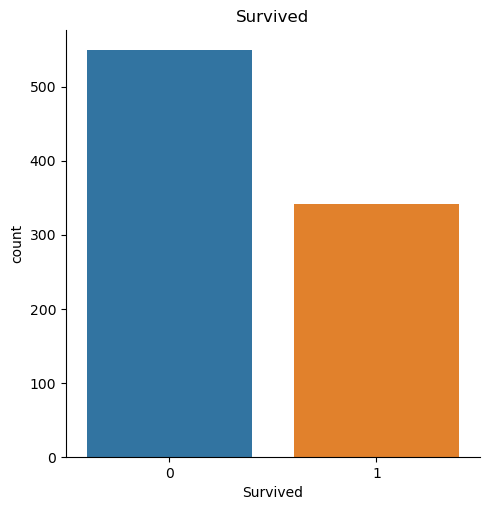

In [141]:
# Survived
sns.catplot(x=dependent_variable, data=train_df, kind='count').set(title=dependent_variable)
plt.show()

`Survived` is relatively balanced (62:38 split).

## Categorical EDA

### Pclass

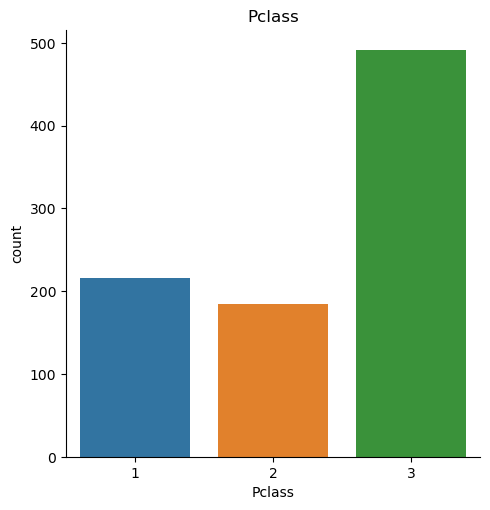

In [142]:
# PClass
sns.catplot(x='Pclass', data=train_df, kind='count').set(title='Pclass')
plt.show()

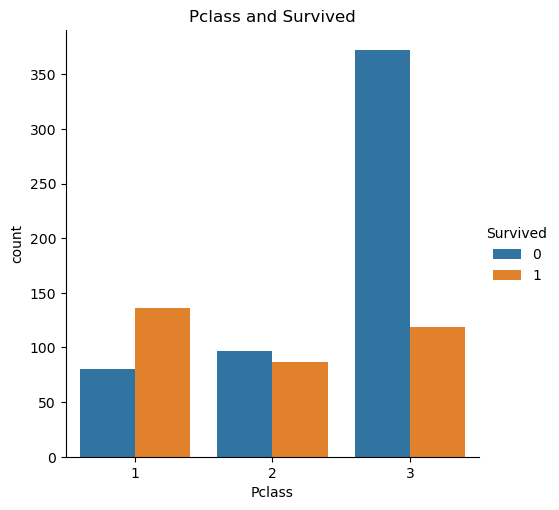

In [143]:
# PClass and Survived
sns.catplot(x='Pclass', hue=dependent_variable, data=train_df, kind='count').set(title='Pclass and Survived')
plt.show()

As expected, `Pclass` appears to be correlated with survival.

### Sex

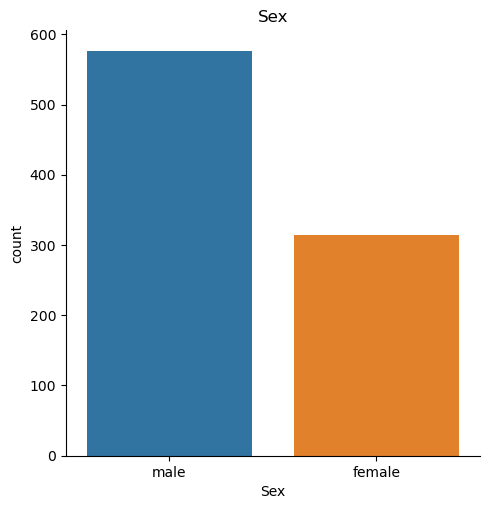

In [144]:
# Sex
sns.catplot(x='Sex', data=train_df, kind='count').set(title='Sex')
plt.show()

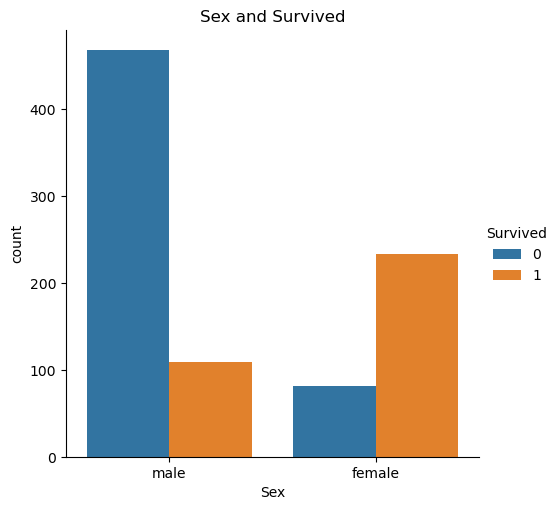

In [145]:
# Sex and Survived
sns.catplot(x='Sex', hue=dependent_variable, data=train_df, kind='count').set(title='Sex and Survived')
plt.show()

`Sex` appears to be correlated with survival.

### Embarked

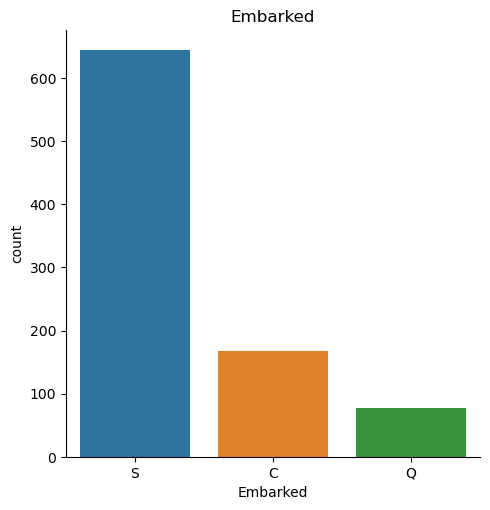

In [146]:
# Embarked
sns.catplot(x='Embarked', data=train_df, kind='count').set(title='Embarked')
plt.show()

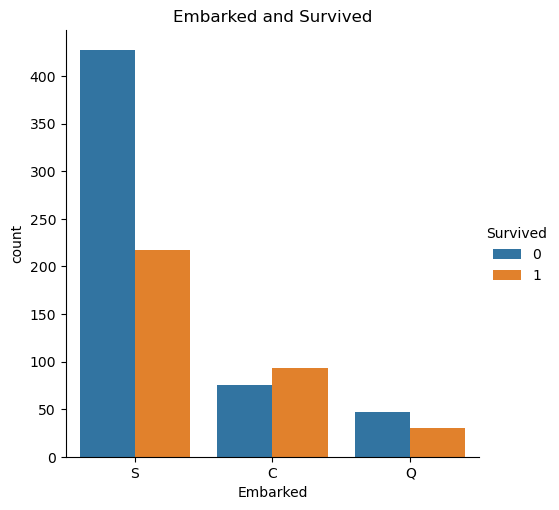

In [147]:
# Embarked and Survived
sns.catplot(x='Embarked', hue=dependent_variable, data=train_df, kind='count').set(title='Embarked and Survived')
plt.show()

`Embarked` appears to be correlated with survival. However,`Embarked` may be correlated with `Pclass` (given the nature of English economic geography at this time).

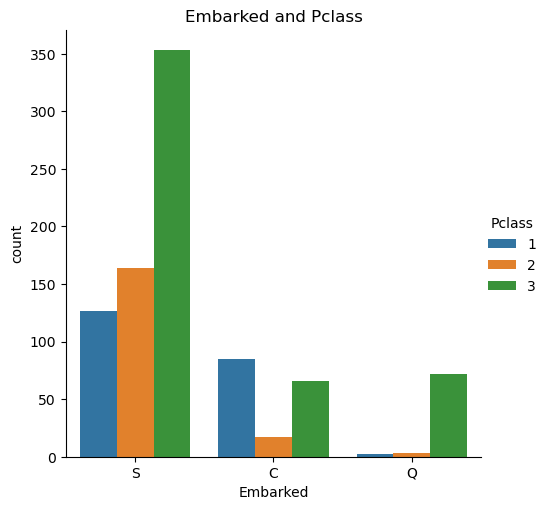

In [148]:
# Embarked and Pclass
sns.catplot(x='Embarked', hue='Pclass', data=train_df, kind='count').set(title='Embarked and Pclass')
plt.show()

S is disproportionately 3rd class. The relationship between `Embarked` appears to be a spurious correlation. `Pclass` is likely the underlying structure driving survival here.

## Quantitative EDA

In [149]:
# basic distributions of train_df
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [150]:
# basic distributions of test_df
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Age

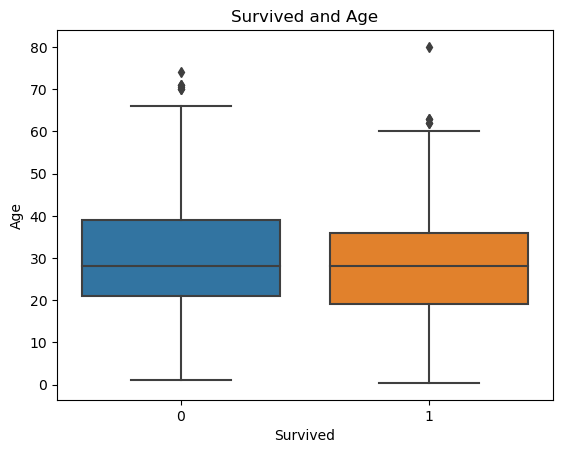

In [151]:
# Survived and Age
sns.boxplot(x=dependent_variable, y='Age', data=train_df).set(title='Survived and Age')
plt.show()

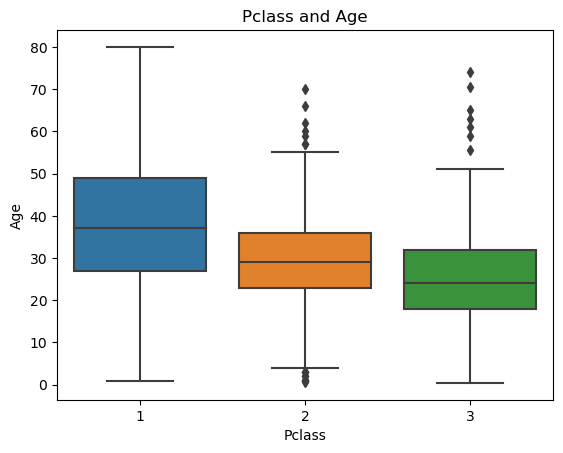

In [152]:
# Pclass and Age
sns.boxplot(x='Pclass', y='Age', data=train_df).set(title='Pclass and Age')
plt.show()

1st class is older than second class which is older than 3rd class on average. Second class has fewer children.

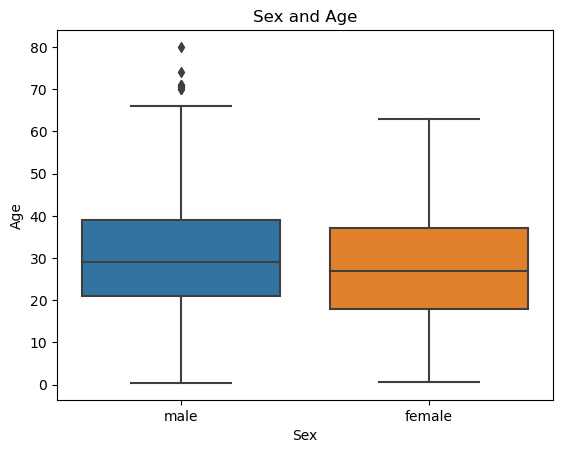

In [153]:
# Sex and Age
sns.boxplot(x='Sex', y='Age', data=train_df).set(title='Sex and Age')
plt.show()

Men were slightly older in general and had all the elderly individuals.

---
# Data Preparation

In [154]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [155]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Null Imputation

**Categorical columns with nulls**

* `Cabin` (train and test)
* `Embarked` (train)

**Numerical columns with nulls**

* `Age` (train and test)
* `Fare` (test)


In [156]:
# Cabin impute using 'NA'
train_df['Cabin'] = train_df['Cabin'].fillna('NA') 
test_df['Cabin'] = test_df['Cabin'].fillna('NA') 

In [157]:
# Embarked impute using mode
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

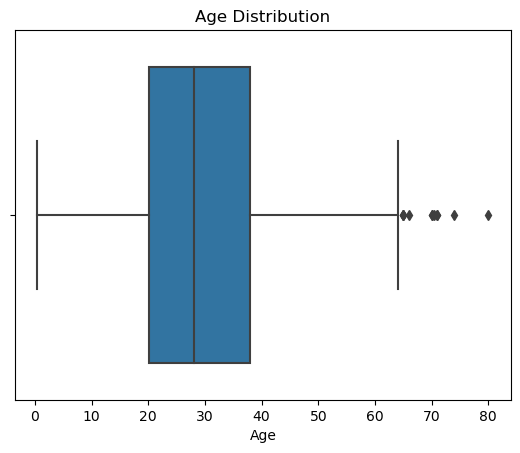

In [158]:
# checking Age for distribution and outliers
sns.boxplot(x='Age', data=train_df).set(title='Age Distribution')
plt.show()

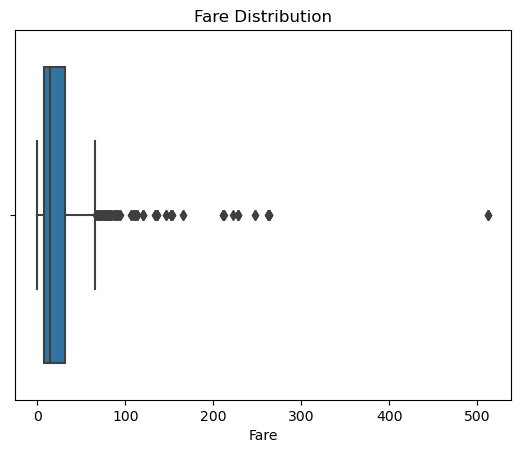

In [159]:
# checking Fare for distribution and outliers
sns.boxplot(x='Fare', data=train_df).set(title='Fare Distribution')
plt.show()

It appears that `Age` is relatively symmetrical and that `Fare` is right skewed. I will use mean imputation for `Age` and median imputation for `Fare`.

In [160]:
# Age impute
train_age_mean = train_df['Age'].mean()

train_df['Age'] = train_df['Age'].fillna(train_age_mean)

test_df['Age'] = test_df['Age'].fillna(train_age_mean)

In [161]:
# Fare impute
train_fare_median = train_df['Fare'].median()

test_df['Fare'] = test_df['Fare'].fillna(train_fare_median)

*Note*: I use attributes from the train dataset in order to impute for the test dataset.

In [162]:
# confirm the imputation worked
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [163]:
# confirm the imputation worked
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


It appears that there are no more null values in either dataset.

## Feature Engineering

### Age Bucket

Bucket `Age` into 'baby', 'child', 'adult', and 'elderly'

In [164]:
# age_bucket
age_bins = [0,1,10,65,100]
age_labels = ['baby','child','adult', 'elderly']

train_df['age_bucket'] = pd.cut(x=train_df['Age'], bins=age_bins,labels=age_labels).astype('object')

test_df['age_bucket'] = pd.cut(x=test_df['Age'], bins=age_bins, labels=age_labels).astype('object')

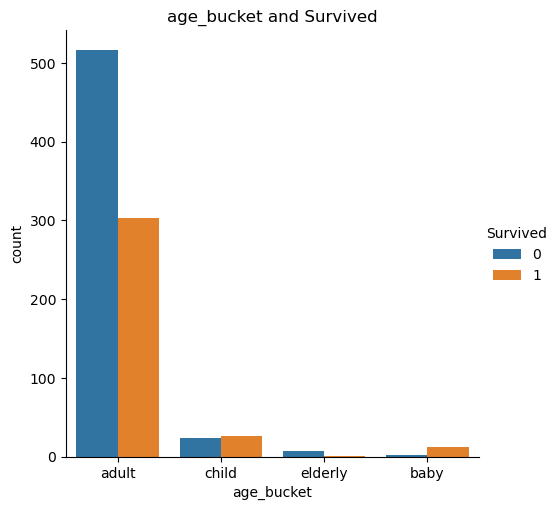

In [165]:
# ship_location and survived
sns.catplot(x='age_bucket', hue=dependent_variable, data=train_df, kind='count').set(title='age_bucket and Survived')
plt.show()

Being either a child or elderly appears to improve survival rate.

### Role

I noticed in examining the data that certain names have titles (Mr, Ms, Don, Capt, etc.) and I want to bucket these into roles.

In [166]:
# extract titles
train_df[['last_name','intermediate']] = train_df['Name'].str.split(', ', expand=True)
train_df[['title','first_name']] = train_df['intermediate'].str.split('.', 1, expand=True)
train_df = train_df.drop(columns=['last_name', 'intermediate', 'first_name'])

test_df[['last_name','intermediate']] = test_df['Name'].str.split(', ', expand=True)
test_df[['title','first_name']] = test_df['intermediate'].str.split('.', 1, expand=True)
test_df = test_df.drop(columns=['last_name', 'intermediate', 'first_name'])

In [167]:
# unique titles
train_title_set = set(train_df['title'].tolist())
test_title_set = set(test_df['title'].tolist())
title_sorted = sorted(train_title_set.union(test_title_set))

print(title_sorted)

['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']


In [168]:
# assign titles to roles
def assign_role(row):
    if row['title'] in ['Capt', 'Col', 'Major']:
        return 'officer'
    elif row['title'] in ['Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Master', 'Rev', 'Sir', 'the Countess']:
        return 'important'
    elif row['title'] in ['Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms']:
        return 'average'
    
train_df['role'] = train_df.apply(lambda row: assign_role(row), axis=1)
test_df['role'] = test_df.apply(lambda row: assign_role(row), axis=1)

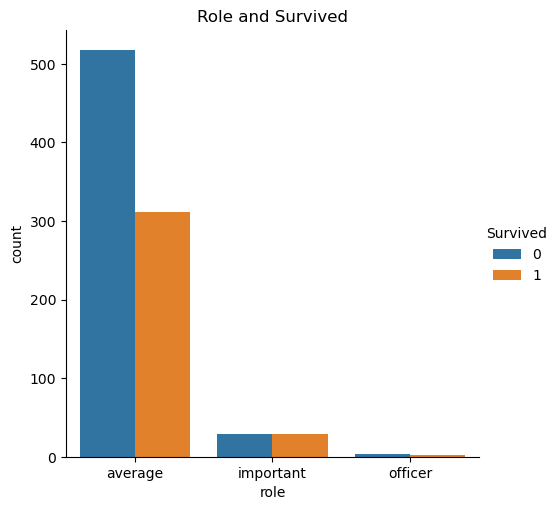

In [169]:
# role and survived
sns.catplot(x='role', hue=dependent_variable, data=train_df, kind='count').set(title='Role and Survived')
plt.show()

Both "important" and "officer" roles appear to improve survival rate.


In [170]:
train_df['name_length'] = train_df['Name'].str.len()
test_df['name_length'] = test_df['Name'].str.len()

### Ship Location

Ship location may matter due to proximity to lifeboats and upper deck access. 

One can refer to the following [article](https://en.wikipedia.org/wiki/First-class_facilities_of_the_Titanic) for a schematic of the titanic's deck.


In [171]:
# unique titles from each data set
train_set = set(train_df['Cabin'].tolist())
test_set = set(test_df['Cabin'].tolist())
sorted_set = sorted(train_set.union(test_set))

print(sorted_set)

print("Number of unique cabins:", len(sorted_set))
print("Number of records:", len(train_df) + len(test_df))

['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23', 'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22', 'B24', 'B26', 'B28', 'B3', 'B30', 'B35', 'B36', 'B37', 'B38', 'B39', 'B4', 'B41', 'B42', 'B45', 'B49', 'B5', 'B50', 'B51 B53 B55', 'B52 B54 B56', 'B57 B59 B63 B66', 'B58 B60', 'B61', 'B69', 'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103', 'C104', 'C105', 'C106', 'C110', 'C111', 'C116', 'C118', 'C123', 'C124', 'C125', 'C126', 'C128', 'C130', 'C132', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C28', 'C30', 'C31', 'C32', 'C39', 'C45', 'C46', 'C47', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55 C57', 'C6', 'C62 C64', 'C65', 'C68', 'C7', 'C70', 'C78', 'C80', 'C82', 'C83', 'C85', 'C86', 'C87', 'C89', 'C90', 'C91', 'C92', 'C93', 'C95', 'C97', 'C99', 'D', 'D10 D12', 'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D22', 'D26', 'D28', 'D30', 'D33', 'D34', 'D35', 'D36

Some passengers have multiple cabins, but they all appear to be in the same general `ship_location`.

There are 187 cabins and 1309 records, therefore some passengers are traveling in the same cabin. We will group by `Cabin` to try and extract information.

In [172]:
# ship_location
train_df['ship_location'] = train_df['Cabin'].astype(str).str[0]
test_df['ship_location'] = test_df['Cabin'].astype(str).str[0]

I want to see if how `ship_location` relates to survival and Pclass.

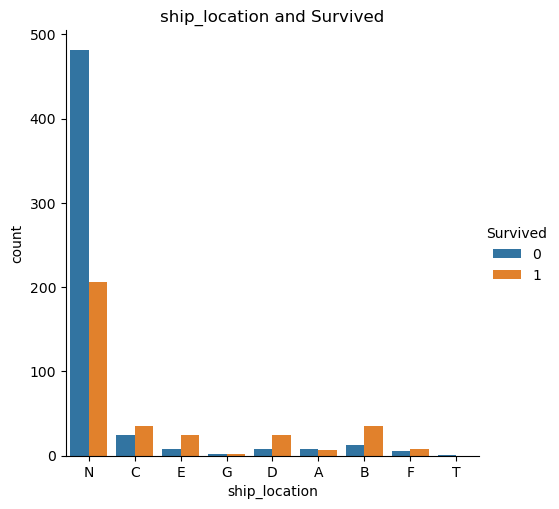

In [173]:
# ship_location and survived
sns.catplot(x='ship_location', hue=dependent_variable, data=train_df, kind='count').set(title='ship_location and Survived')
plt.show()

Some locations appear to correlate with higher chances of survival.

This also makes me think that passenger class correlates with having been assigned a cabin at all.

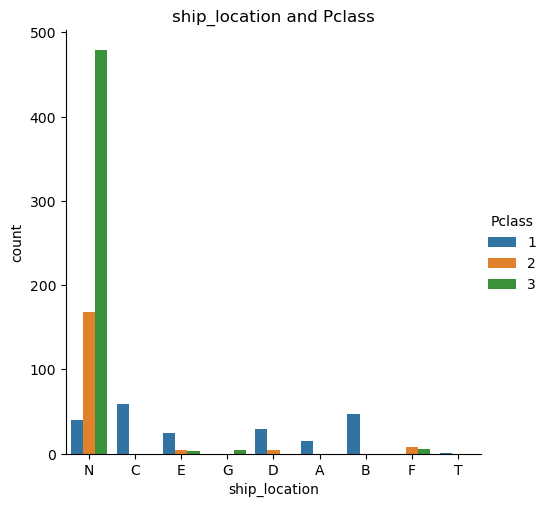

In [174]:
# ship_location and Pclass
sns.catplot(x='ship_location', hue='Pclass', data=train_df, kind='count').set(title='ship_location and Pclass')
plt.show()

Pclass correlates with having been assigned a cabin.

In [175]:
# function for re-use
def group_by_shared_feature(train_df, test_df, col):
    col_list = [col, 'Sex', 'age_bucket', 'role']
    
    train_df = train_df[col_list].copy()
    test_df = test_df[col_list].copy()

    df = pd.concat([train_df, test_df])
    df = pd.get_dummies(df, columns=col_list[1:])

    agg_df = df.groupby(by=col).agg({
        "Sex_male" : 'mean',
        "age_bucket_adult" : 'mean',
        "role_average" : 'mean'
    }).reset_index()
    
    agg_df.columns = [col, f'{col}_male_perc', f'{col}_adult_perc', f'{col}_average_role_perc']
    
    return agg_df

The idea here is that higher male, adult, and average role percentages decreases survivability for everyone in the group.

In [176]:
# group by cabin
col = 'Cabin'
agg_df = group_by_shared_feature(train_df, test_df, col)

train_df = pd.merge(train_df, agg_df, how='left', on=col)
test_df = pd.merge(test_df, agg_df, how='left', on=col)

### Ticket

We may be able to link passengers that are traveling together to the same ticket.

In [177]:
# compare unique tickets
train_set = set(train_df['Ticket'].tolist())
test_set = set(test_df['Ticket'].tolist())
sorted_set = sorted(train_set.union(test_set))

print("Number of unique tickets:", len(sorted_set))
print("Number of records:", len(train_df) + len(test_df))

Number of unique tickets: 929
Number of records: 1309


In [178]:
# group by ticket
col = 'Ticket'
agg_df = group_by_shared_feature(train_df, test_df, col)

train_df = pd.merge(train_df, agg_df, how='left', on=col)
test_df = pd.merge(test_df, agg_df, how='left', on=col)

In [179]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,title,role,name_length,ship_location,Cabin_male_perc,Cabin_adult_perc,Cabin_average_role_perc,Ticket_male_perc,Ticket_adult_perc,Ticket_average_role_perc
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,average,23,N,0.679487,0.922091,0.933925,1.0,1.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,average,51,C,0.500000,1.000000,1.000000,0.5,1.0,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,average,22,N,0.679487,0.922091,0.933925,0.0,1.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,average,44,C,0.500000,1.000000,1.000000,0.5,1.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,average,24,N,0.679487,0.922091,0.933925,1.0,1.0,1.0


### Family Size

Family size is total amount of siblings, spouses, parents and children.

In [180]:
# family_size
train_df['family_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['family_size'] = test_df['SibSp'] + test_df['Parch'] + 1

I want to see how family_size relates to survival.

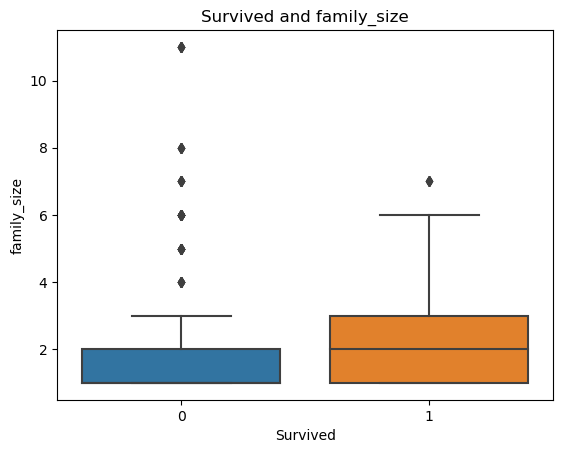

In [181]:
# survival and family_size
sns.boxplot(x='Survived', y='family_size', data=train_df).set(title='Survived and family_size')
plt.show()

It appears larger overall families survive more. This surprises me. Lets examine it further by treating it like a categorical variable.

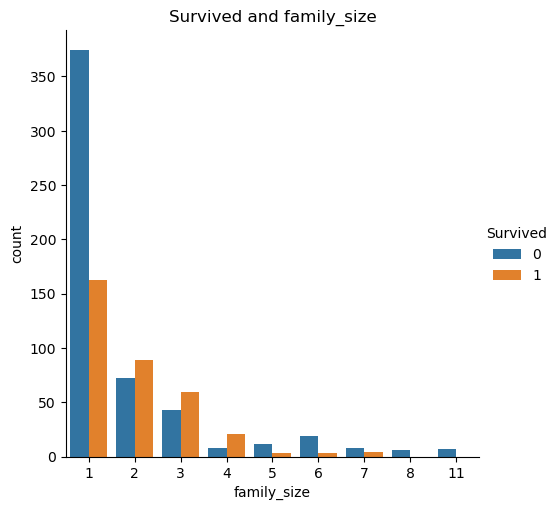

In [182]:
# family_size and survived
sns.catplot(x='family_size', hue=dependent_variable, data=train_df, kind='count').set(title='Survived and family_size')
plt.show()

Solo travelers have a much different outcome.



### Solo Travelers

In [183]:
# create convert to binary
train_df['travel_solo'] = train_df['family_size'].apply(lambda x: 1 if x==1 else 0)
test_df['travel_solo'] = test_df['family_size'].apply(lambda x: 1 if x==1 else 0)

### Drop Columns

In [184]:
# drop columns
drop_col_list = ['Name', 'Ticket', 'Cabin', 'title']

train_df.drop(drop_col_list, inplace=True, axis=1)
test_df.drop(drop_col_list, inplace=True, axis=1)

### Encode Categorical

In [185]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               891 non-null    int64  
 1   Survived                  891 non-null    int64  
 2   Pclass                    891 non-null    int64  
 3   Sex                       891 non-null    object 
 4   Age                       891 non-null    float64
 5   SibSp                     891 non-null    int64  
 6   Parch                     891 non-null    int64  
 7   Fare                      891 non-null    float64
 8   Embarked                  891 non-null    object 
 9   age_bucket                891 non-null    object 
 10  role                      891 non-null    object 
 11  name_length               891 non-null    int64  
 12  ship_location             891 non-null    object 
 13  Cabin_male_perc           891 non-null    float64
 14  Cabin_adul

In [186]:
# make dummies for the remainder
dummy_col_list = ['Pclass', 'Sex', 'Embarked', 'age_bucket', 'role', 'ship_location']

# convert to dummy percentages for the remainder
for col in dummy_col_list:
    col_agg_df = train_df.groupby(by=col).agg({dependent_variable : 'mean'}).reset_index()
    col_agg_df.columns = [col, f'{col}_survival']
    
    train_df = pd.merge(train_df, col_agg_df, how='left', on=col)
    test_df = pd.merge(test_df, col_agg_df, how='left', on=col)

# get dummies
train_df = pd.get_dummies(train_df, columns=dummy_col_list)
test_df = pd.get_dummies(test_df, columns=dummy_col_list)

### Transform Numerical

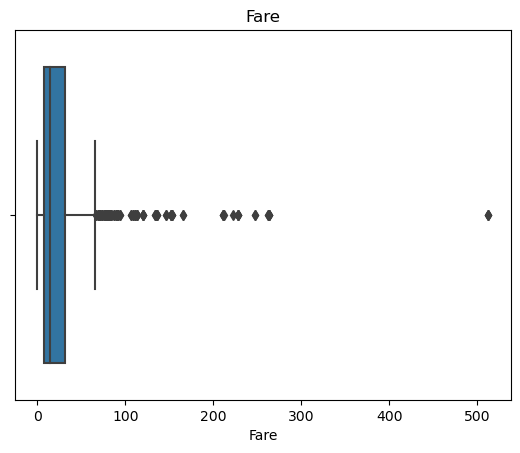

In [187]:
# Fare
sns.boxplot(x='Fare', data=train_df).set(title='Fare')
plt.show()

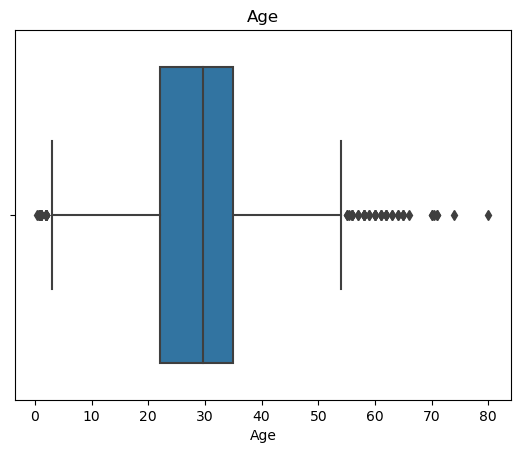

In [188]:
# Age
sns.boxplot(x='Age', data=train_df).set(title='Age')
plt.show()

`Fare` is right-skewed. I will log transform.

In [189]:
# log transform Fare
train_df['fare_log'] = np.log(train_df['Fare']+1)
test_df['fare_log'] = np.log(test_df['Fare']+1)

## Column Confirmation

In [190]:
# confirm that both df have the same dimensions at this point
train_set = set(train_df.columns)
test_set = set(test_df.columns)

test_train_diff_set = test_set - train_set
train_test_diff_set = train_set - test_set
train_test_union_set = train_set.intersection(test_set)
print(f'Missing columns in test not in train: {test_train_diff_set}')
print(f'Missing columns in train not in test: {train_test_diff_set}')

Missing columns in test not in train: set()
Missing columns in train not in test: {'Survived', 'ship_location_T'}


In [191]:
# make sure there are no differences in columns
train_col_list = list(train_test_union_set)
train_col_list.append(dependent_variable)

test_col_list = list(train_test_union_set)

train_df = train_df[train_col_list].copy()
test_df = test_df[test_col_list].copy()

In [192]:
# confirm that both df have the same dimensions at this point
train_set = set(train_df.columns)
test_set = set(test_df.columns)

test_train_diff_set = test_set - train_set
train_test_diff_set = train_set - test_set
train_test_union_set = train_set.intersection(test_set)
print(f'Missing columns in test not in train: {test_train_diff_set}')
print(f'Missing columns in train not in test: {train_test_diff_set}')

Missing columns in test not in train: set()
Missing columns in train not in test: {'Survived'}


# Modeling

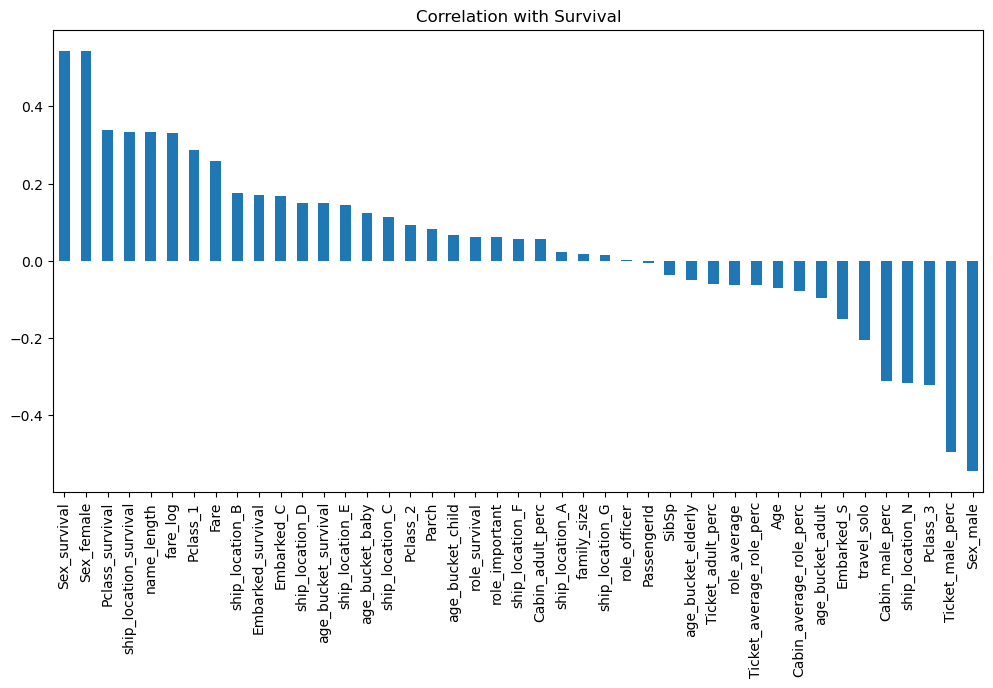

In [193]:
# correlation graph with survival
correlation = train_df.iloc[:, 1:].corr()[dependent_variable].sort_values(ascending=False)

correlation[1:].plot(kind='bar', figsize=(12,6), title='Correlation with Survival')
plt.show()

In [194]:
# split train into x and y
y_train = train_df[dependent_variable].copy()
x_train = train_df.drop(columns=[dependent_variable], axis=1).copy()

In [195]:
# make sure dependent variable is gone
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Embarked_Q                891 non-null    uint8  
 1   ship_location_F           891 non-null    uint8  
 2   Pclass_2                  891 non-null    uint8  
 3   Ticket_adult_perc         891 non-null    float64
 4   Ticket_male_perc          891 non-null    float64
 5   role_survival             891 non-null    float64
 6   Cabin_average_role_perc   891 non-null    float64
 7   ship_location_C           891 non-null    uint8  
 8   role_important            891 non-null    uint8  
 9   age_bucket_survival       891 non-null    float64
 10  Sex_female                891 non-null    uint8  
 11  Embarked_S                891 non-null    uint8  
 12  ship_location_survival    891 non-null    float64
 13  Fare                      891 non-null    float64
 14  age_bucket

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

In [197]:
# shared parameters
cv = 10
random_state=42
n_jobs = -1

base_params = {
    'random_state': random_state,
    'n_jobs': n_jobs
}

In [211]:
def feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, select_features=False, best_features=None):
    # use known best features
    if best_features is not None:
        print("Using known best features")
        selected_features = best_features.copy()
    
    # select features
    elif select_features == True:
        print("Selecting features")
        sfs = SequentialFeatureSelector(
            model, 
            scoring='accuracy', 
            direction='backward',
            cv=cv,
            n_jobs=n_jobs
        )

        sfs.fit(x_train, y_train)
        selected_features = list(sfs.get_feature_names_out())
    else:
        print("Skipping feature selection")
        selected_features = list(x_train.columns)[1:]
        
    print("Features:")
    print(selected_features)

    # grid search CV to pick features
    print("Searching for best hyperparameters")
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        n_jobs=n_jobs,
        scoring='accuracy'
    )
    
    grid_search.fit(x_train[selected_features].values, y_train.values)
    
    best_hyperparameters = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best hyperparameters:", best_hyperparameters)
    print("Best mean cross-validated score:", best_score)
    
    return selected_features, best_hyperparameters

In [208]:
rf_best_features = [
    'ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_survival', 'Cabin_average_role_perc', 'ship_location_C', 
    'role_important', 'age_bucket_survival', 'Sex_female', 'Embarked_S', 'ship_location_survival', 'Fare', 'age_bucket_baby', 'Parch', 
    'family_size', 'ship_location_B', 'ship_location_E', 'Cabin_adult_perc', 'age_bucket_adult', 'age_bucket_elderly', 'Age', 'Pclass_3', 
    'fare_log', 'travel_solo', 'Cabin_male_perc', 'Pclass_1', 'Ticket_average_role_perc', 'Sex_survival', 'SibSp', 'ship_location_G', 
    'ship_location_D', 'Sex_male', 'PassengerId', 'name_length', 'role_officer', 'ship_location_N', 'age_bucket_child', 'Embarked_C', 
    'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']

xgb_best_features = ['Embarked_Q', 'Ticket_adult_perc', 'Ticket_male_perc', 'Cabin_average_role_perc', 'role_important', 'age_bucket_survival', 
                     'ship_location_survival', 'Fare', 'Parch', 'ship_location_B', 'Cabin_adult_perc', 'Cabin_male_perc', 
                     'Ticket_average_role_perc', 'SibSp', 'Sex_male', 'name_length', 'ship_location_N', 'age_bucket_child', 'ship_location_A', 
                     'role_average', 'Pclass_survival', 'Embarked_survival']

lgbm_best_features = ['Embarked_Q', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'ship_location_C', 'role_important', 'age_bucket_survival', 
                      'Embarked_S', 'ship_location_survival', 'Fare', 'Parch', 'family_size', 'ship_location_B', 'age_bucket_adult', 'Pclass_3', 
                      'Cabin_male_perc', 'SibSp', 'Sex_male', 'name_length', 'role_average', 'Pclass_survival', 'Embarked_survival']

## Random Forest Classifier

### No Feature Selection

In [227]:
# random forest classifier
print("Building random forest model")
model = RandomForestClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'min_samples_split': [3],
    'min_samples_leaf': [1]
}

rf_selected_features, rf_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=None)

# fit model
rf_model = RandomForestClassifier(**{**base_params,**rf_best_hyperparameters})
rf_model.fit(x_train[rf_selected_features].values, y_train.values)

Building random forest model
Skipping feature selection
Features:
['ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_survival', 'Cabin_average_role_perc', 'ship_location_C', 'role_important', 'age_bucket_survival', 'Sex_female', 'Embarked_S', 'ship_location_survival', 'Fare', 'age_bucket_baby', 'Parch', 'family_size', 'ship_location_B', 'ship_location_E', 'Cabin_adult_perc', 'age_bucket_adult', 'age_bucket_elderly', 'Age', 'Pclass_3', 'fare_log', 'travel_solo', 'Cabin_male_perc', 'Pclass_1', 'Ticket_average_role_perc', 'Sex_survival', 'SibSp', 'ship_location_G', 'ship_location_D', 'Sex_male', 'PassengerId', 'name_length', 'role_officer', 'ship_location_N', 'age_bucket_child', 'Embarked_C', 'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']
Searching for best hyperparameters
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}
Best mean cross-validated score: 0.837278401997503


RandomForestClassifier(max_depth=8, min_samples_split=3, n_estimators=1000,
                       n_jobs=-1, random_state=42)

### Best RF Features

In [212]:
# random forest classifier
print("Building random forest model")
model = RandomForestClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'min_samples_split': [3],
    'min_samples_leaf': [1]
}

rf_selected_features, rf_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=rf_best_features)

# fit model
rf_model = RandomForestClassifier(**{**base_params,**rf_best_hyperparameters})
rf_model.fit(x_train[rf_selected_features].values, y_train.values)

Building random forest model
Using known best features
Features:
['ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_survival', 'Cabin_average_role_perc', 'ship_location_C', 'role_important', 'age_bucket_survival', 'Sex_female', 'Embarked_S', 'ship_location_survival', 'Fare', 'age_bucket_baby', 'Parch', 'family_size', 'ship_location_B', 'ship_location_E', 'Cabin_adult_perc', 'age_bucket_adult', 'age_bucket_elderly', 'Age', 'Pclass_3', 'fare_log', 'travel_solo', 'Cabin_male_perc', 'Pclass_1', 'Ticket_average_role_perc', 'Sex_survival', 'SibSp', 'ship_location_G', 'ship_location_D', 'Sex_male', 'PassengerId', 'name_length', 'role_officer', 'ship_location_N', 'age_bucket_child', 'Embarked_C', 'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']
Searching for best hyperparameters
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}
Best mean cross-validated score: 0.837278401997503


RandomForestClassifier(max_depth=8, min_samples_split=3, n_estimators=1000,
                       n_jobs=-1, random_state=42)

### Best XGB Features

In [223]:
# random forest classifier
print("Building random forest model")
model = RandomForestClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'min_samples_split': [3],
    'min_samples_leaf': [1]
}

rf_selected_features, rf_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=xgb_best_features)

# fit model
rf_model = RandomForestClassifier(**{**base_params,**rf_best_hyperparameters})
rf_model.fit(x_train[rf_selected_features].values, y_train.values)

Building random forest model
Using known best features
Features:
['Embarked_Q', 'Ticket_adult_perc', 'Ticket_male_perc', 'Cabin_average_role_perc', 'role_important', 'age_bucket_survival', 'ship_location_survival', 'Fare', 'Parch', 'ship_location_B', 'Cabin_adult_perc', 'Cabin_male_perc', 'Ticket_average_role_perc', 'SibSp', 'Sex_male', 'name_length', 'ship_location_N', 'age_bucket_child', 'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']
Searching for best hyperparameters
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}
Best mean cross-validated score: 0.8271910112359551


RandomForestClassifier(max_depth=8, min_samples_split=3, n_estimators=1000,
                       n_jobs=-1, random_state=42)

### Best LGBM Features

In [226]:
# random forest classifier
print("Building random forest model")
model = RandomForestClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'min_samples_split': [3],
    'min_samples_leaf': [1]
}

rf_selected_features, rf_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=lgbm_best_features)

# fit model
rf_model = RandomForestClassifier(**{**base_params,**rf_best_hyperparameters})
rf_model.fit(x_train[rf_selected_features].values, y_train.values)

Building random forest model
Using known best features
Features:
['ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_important', 'Sex_female', 'ship_location_survival', 'Fare', 'ship_location_B', 'ship_location_E', 'age_bucket_elderly', 'Age', 'Pclass_3', 'fare_log', 'Cabin_male_perc', 'Sex_survival', 'ship_location_G', 'PassengerId', 'role_officer', 'age_bucket_child', 'Embarked_C', 'ship_location_A']
Searching for best hyperparameters
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}
Best mean cross-validated score: 0.8462671660424469


RandomForestClassifier(max_depth=8, min_samples_split=3, n_estimators=1000,
                       n_jobs=-1, random_state=42)

## XGBoost Classifier

### No Feature Selection

In [221]:
# xgboost classifier
print("Building XGBoost model")
model = XGBClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'learning_rate': [0.005]
}

xgb_selected_features, xgb_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=None)

# fit model
xgb_model = XGBClassifier(**{**base_params,**xgb_best_hyperparameters})
xgb_model.fit(x_train[xgb_selected_features].values, y_train.values)

Building XGBoost model
Skipping feature selection
Features:
['ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_survival', 'Cabin_average_role_perc', 'ship_location_C', 'role_important', 'age_bucket_survival', 'Sex_female', 'Embarked_S', 'ship_location_survival', 'Fare', 'age_bucket_baby', 'Parch', 'family_size', 'ship_location_B', 'ship_location_E', 'Cabin_adult_perc', 'age_bucket_adult', 'age_bucket_elderly', 'Age', 'Pclass_3', 'fare_log', 'travel_solo', 'Cabin_male_perc', 'Pclass_1', 'Ticket_average_role_perc', 'Sex_survival', 'SibSp', 'ship_location_G', 'ship_location_D', 'Sex_male', 'PassengerId', 'name_length', 'role_officer', 'ship_location_N', 'age_bucket_child', 'Embarked_C', 'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']
Searching for best hyperparameters
Best hyperparameters: {'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 1000}
Best mean cross-validated score: 0.8170786516853932


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.005, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

### Best XGB Features

In [213]:
# xgboost classifier
print("Building XGBoost model")
model = XGBClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'learning_rate': [0.005]
}

xgb_selected_features, xgb_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=xgb_best_features)

# fit model
xgb_model = XGBClassifier(**{**base_params,**xgb_best_hyperparameters})
xgb_model.fit(x_train[xgb_selected_features].values, y_train.values)

Building XGBoost model
Using known best features
Features:
['Embarked_Q', 'Ticket_adult_perc', 'Ticket_male_perc', 'Cabin_average_role_perc', 'role_important', 'age_bucket_survival', 'ship_location_survival', 'Fare', 'Parch', 'ship_location_B', 'Cabin_adult_perc', 'Cabin_male_perc', 'Ticket_average_role_perc', 'SibSp', 'Sex_male', 'name_length', 'ship_location_N', 'age_bucket_child', 'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']
Searching for best hyperparameters
Best hyperparameters: {'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 1000}
Best mean cross-validated score: 0.8271910112359551


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.005, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

### Best LGBM Features

In [228]:
# xgboost classifier
print("Building XGBoost model")
model = XGBClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'learning_rate': [0.005]
}

xgb_selected_features, xgb_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=lgbm_best_features)

# fit model
xgb_model = XGBClassifier(**{**base_params,**xgb_best_hyperparameters})
xgb_model.fit(x_train[xgb_selected_features].values, y_train.values)

Building XGBoost model
Using known best features
Features:
['ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_important', 'Sex_female', 'ship_location_survival', 'Fare', 'ship_location_B', 'ship_location_E', 'age_bucket_elderly', 'Age', 'Pclass_3', 'fare_log', 'Cabin_male_perc', 'Sex_survival', 'ship_location_G', 'PassengerId', 'role_officer', 'age_bucket_child', 'Embarked_C', 'ship_location_A']
Searching for best hyperparameters
Best hyperparameters: {'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 1000}
Best mean cross-validated score: 0.7980149812734082


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.005, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

## LightGBM Classifier

### No Feature Selection

In [222]:
# random forest classifier
print("Building lightgbm model")
model = LGBMClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'learning_rate': [0.005]
}

lgbm_selected_features, lgbm_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=None)

# fit model
rf_model = LGBMClassifier(**{**base_params,**lgbm_best_hyperparameters})
rf_model.fit(x_train[lgbm_selected_features].values, y_train.values)

Building lightgbm model
Skipping feature selection
Features:
['ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_survival', 'Cabin_average_role_perc', 'ship_location_C', 'role_important', 'age_bucket_survival', 'Sex_female', 'Embarked_S', 'ship_location_survival', 'Fare', 'age_bucket_baby', 'Parch', 'family_size', 'ship_location_B', 'ship_location_E', 'Cabin_adult_perc', 'age_bucket_adult', 'age_bucket_elderly', 'Age', 'Pclass_3', 'fare_log', 'travel_solo', 'Cabin_male_perc', 'Pclass_1', 'Ticket_average_role_perc', 'Sex_survival', 'SibSp', 'ship_location_G', 'ship_location_D', 'Sex_male', 'PassengerId', 'name_length', 'role_officer', 'ship_location_N', 'age_bucket_child', 'Embarked_C', 'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']
Searching for best hyperparameters
Best hyperparameters: {'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 1000}
Best mean cross-validated score: 0.823820224719101


LGBMClassifier(learning_rate=0.005, max_depth=8, n_estimators=1000,
               random_state=42)

### Best LGBM Features

In [218]:
# random forest classifier
print("Building lightgbm model")
model = LGBMClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'learning_rate': [0.005]
}

lgbm_selected_features, lgbm_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=lgbm_best_features)

# fit model
rf_model = LGBMClassifier(**{**base_params,**lgbm_best_hyperparameters})
rf_model.fit(x_train[lgbm_selected_features].values, y_train.values)

Building lightgbm model
Using known best features
Features:
['ship_location_F', 'Pclass_2', 'Ticket_adult_perc', 'Ticket_male_perc', 'role_important', 'Sex_female', 'ship_location_survival', 'Fare', 'ship_location_B', 'ship_location_E', 'age_bucket_elderly', 'Age', 'Pclass_3', 'fare_log', 'Cabin_male_perc', 'Sex_survival', 'ship_location_G', 'PassengerId', 'role_officer', 'age_bucket_child', 'Embarked_C', 'ship_location_A']
Searching for best hyperparameters
Best hyperparameters: {'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 1000}
Best mean cross-validated score: 0.8025093632958802


LGBMClassifier(learning_rate=0.005, max_depth=8, n_estimators=1000,
               random_state=42)

### Best XGB Features

In [229]:
# random forest classifier
print("Building lightgbm model")
model = LGBMClassifier().set_params(**base_params)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [8],
    'learning_rate': [0.005]
}

lgbm_selected_features, lgbm_best_hyperparameters = feature_select_grid_search_model(x_train, y_train, model, param_grid, cv, n_jobs, 
                                                                                 select_features=False,
                                                                                 best_features=xgb_best_features)

# fit model
rf_model = LGBMClassifier(**{**base_params,**lgbm_best_hyperparameters})
rf_model.fit(x_train[lgbm_selected_features].values, y_train.values)

Building lightgbm model
Using known best features
Features:
['Embarked_Q', 'Ticket_adult_perc', 'Ticket_male_perc', 'Cabin_average_role_perc', 'role_important', 'age_bucket_survival', 'ship_location_survival', 'Fare', 'Parch', 'ship_location_B', 'Cabin_adult_perc', 'Cabin_male_perc', 'Ticket_average_role_perc', 'SibSp', 'Sex_male', 'name_length', 'ship_location_N', 'age_bucket_child', 'ship_location_A', 'role_average', 'Pclass_survival', 'Embarked_survival']
Searching for best hyperparameters
Best hyperparameters: {'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 1000}
Best mean cross-validated score: 0.8283520599250936


LGBMClassifier(learning_rate=0.005, max_depth=8, n_estimators=1000,
               random_state=42)

---
# Submission

In [230]:
final_model = lgbm_model
final_features = lgbm_selected_features

In [231]:
# construct submission
submission_df = pd.DataFrame()
submission_df['PassengerId'] = test_df['PassengerId'].copy()

test_df.drop(columns=['PassengerId'], inplace=True)

submission_df['Survived'] = final_model.predict(test_df[final_features].values)

submission_df.to_csv('submission.csv', index=False)

KeyError: 'PassengerId'

agg_cabin_df## Result
My public score for this notebook was 0.80622 at the original time of submission.

This put me at 320/13413 (top 3%) on the leaderboard.